In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error

from keras.layers.advanced_activations import LeakyReLU
import os
from pandas import DataFrame
from numpy import concatenate

from sklearn.model_selection import GridSearchCV
import datetime
from math import sqrt
from keras import regularizers
import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
def remove_outliers(data, threshold=5):
    mean= data.mean()
    std= data.std()
    idx= np.abs((data-mean)/std) <= threshold
    return data[idx].reshape(-1, 1)

In [4]:
#********Load data**************************

dataset = pd.read_csv('../Paper1/spamkevin.csv', usecols=[0])
dataset.dropna(0,inplace= True)
dataset= np.array(dataset)
print('dataset with outlier', dataset.shape)
dataset= dataset.astype('float32')
dataset= remove_outliers(dataset)
print('dataset after removing outlier', dataset.shape)

# *****************split into train and test sets********************

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
data_train = dataset[0:train_size]
data_test = dataset[train_size:len(dataset)]
print('Data_train', data_train.shape, 'Data_test',data_test.shape)

# ********Normalize the data******************

scaler= MinMaxScaler (feature_range= (-1,1))
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)
print('Train_scaled',train_scaled.shape,' Test scaled', test_scaled.shape)

dataset with outlier (13544, 1)
dataset after removing outlier (13463, 1)
Data_train (10770, 1) Data_test (2693, 1)
Train_scaled (10770, 1)  Test scaled (2693, 1)


In [5]:
# ******************frame a sequence as a supervised learning problem*************

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled , look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled , look_back)

print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

train_X (10766, 3) train_y (10766,)
test_X (2689, 3) test_y (2689,)


In [6]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

# convert 1 D to 2D array
#test_y = test_y.reshape((test_y.shape[0], 1))
#print(test_y.shape)

train_X (10766, 3, 1) train_y (10766,)
test_X (2689, 3, 1) test_y (2689,)


In [7]:
#**********RPE******************************
def rpe(y_true, y_pred):
    
    return backend.abs((y_pred - y_true)/y_true) * 100

In [8]:
#********************Build Model****************************

def build_model (initializer):
    
    model = tf.keras.models.Sequential()
    model.add(SimpleRNN(128, input_shape=(look_back, 1),kernel_initializer=initializer, bias_initializer='zeros',
                        activation='relu', return_sequences= True))
    #model.add(Dropout(0.5))
    model.add(SimpleRNN(64,kernel_initializer=initializer, bias_initializer='zeros', activation='relu' ))
    #model.add(Dropout(0.5))
    model.add(Dense(1))
    model.summary()
    
     #optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer= 'adam', loss='mean_squared_error', metrics= [rpe])
    model.fit (train_X, train_y)
    
    return model


# Glorot uniform

In [9]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model_glorot =build_model('glorot_uniform')

history1 = model_glorot.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 135us/sample - loss: 0.0415 - rpe: 23.3461
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 1s 67us/sample - loss: 0.0343 - rpe: 22.9490 - val_loss: 0.0256 - val_rpe: 18.1532
Epoch 2/1000
8612/8612 [==============================] - 0s 26us/sample - loss: 0.0338 - rpe: 22.71

In [10]:
# **************************Model Performance Error  metrics*************************************

hist1 = pd.DataFrame(history1.history)
hist1['epoch'] = history1.epoch
print(hist1.tail())

# save results
hist1.to_csv('glorot_uniform.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.029741  20.964193  0.028886  20.389015    995
996  0.029700  21.029877  0.028086  19.998495    996
997  0.030205  21.057177  0.028705  20.216299    997
998  0.029752  20.953537  0.028664  20.066055    998
999  0.029857  21.241077  0.028306  20.059824    999


# Glorot normal

In [11]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('glorot_normal')

history2 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 84us/sample - loss: 0.0451 - rpe: 23.8590
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 0s 39us/sample - loss: 0.0340 - rpe: 22.8904 - val_loss: 0.0263 - val_rpe: 19.6929
Epoch 2/1000
8612/8612 [==============================] - 0s 17us/sample - loss: 0.0336 - rpe: 22.6

In [12]:
# **************************Model Performance Error  metrics*************************************

hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
print(hist2.tail())

# save results
hist2.to_csv('glorot_normal.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.029692  20.893637  0.029548  20.313004    995
996  0.029586  20.967083  0.029865  20.358217    996
997  0.029610  20.970850  0.029604  20.290230    997
998  0.029995  21.139704  0.030506  20.597866    998
999  0.030912  21.351782  0.029205  19.977207    999


# He uniform

In [13]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model_he =build_model('he_uniform')

history3 = model_he.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 87us/sample - loss: 0.0547 - rpe: 26.0044
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 0s 39us/sample - loss: 0.0355 - rpe: 22.2380 - val_loss: 0.0304 - val_rpe: 21.0242
Epoch 2/1000
8612/8612 [==============================] - 0s 17us/sample - loss: 0.0349 - rpe: 22.3

In [14]:
# **************************Model Performance Error  metrics*************************************

hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch
print(hist3.tail())

# save results
hist3.to_csv('he_uniform.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.030389  21.204636  0.028102  20.247152    995
996  0.030698  21.376999  0.027864  20.466372    996
997  0.030448  21.193237  0.028457  20.578449    997
998  0.030303  21.223309  0.028044  20.499794    998
999  0.030201  21.080807  0.028431  20.409916    999


# He normal

In [15]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('he_normal')

history4 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 97us/sample - loss: 0.0568 - rpe: 25.3262
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 0s 41us/sample - loss: 0.0359 - rpe: 22.3576 - val_loss: 0.0325 - val_rpe: 22.2296
Epoch 2/1000
8612/8612 [==============================] - 0s 20us/sample - loss: 0.0353 - rpe: 22.5

In [16]:
# **************************Model Performance Error  metrics*************************************

hist4 = pd.DataFrame(history4.history)
hist4['epoch'] = history4.epoch
print(hist4.tail())

# save results
hist4.to_csv('he_normal.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.029796  21.014124  0.028577  20.699326    995
996  0.029699  20.950460  0.029145  20.556969    996
997  0.029785  20.957808  0.028347  20.540281    997
998  0.029735  21.048450  0.028545  20.477928    998
999  0.029653  20.924177  0.028938  20.564529    999


# Lecun uniform

In [17]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model_lecun =build_model('lecun_uniform')

history5 = model_lecun.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 119us/sample - loss: 0.0404 - rpe: 23.5971
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 1s 59us/sample - loss: 0.0357 - rpe: 22.6800 - val_loss: 0.0287 - val_rpe: 19.3512
Epoch 2/1000
8612/8612 [==============================] - 0s 27us/sample - loss: 0.0348 - rpe: 22.

In [18]:
# **************************Model Performance Error  metrics*************************************

hist5 = pd.DataFrame(history5.history)
hist5['epoch'] = history5.epoch
print(hist5.tail())

# save results
hist5.to_csv('lecun_uniform.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.029754  20.940834  0.028403  20.472244    995
996  0.029630  20.936460  0.028138  20.286098    996
997  0.029706  20.891617  0.028223  20.385384    997
998  0.029741  20.966476  0.028523  20.492350    998
999  0.029715  20.999195  0.028744  20.481375    999


# Lecun normal

In [19]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model =build_model('lecun_normal')

history6 = model.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 109us/sample - loss: 0.0544 - rpe: 24.7090
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 0s 48us/sample - loss: 0.0361 - rpe: 22.9171 - val_loss: 0.0274 - val_rpe: 18.4148
Epoch 2/1000
8612/8612 [==============================] - 0s 21us/sample - loss: 0.0342 - rpe: 22.

In [20]:
# **************************Model Performance Error  metrics*************************************

hist6 = pd.DataFrame(history6.history)
hist6['epoch'] = history6.epoch
print(hist6.tail())

# save results
hist6.to_csv('lecun_normal.csv')

         loss        rpe  val_loss    val_rpe  epoch
995  0.029546  20.897415  0.030101  20.758337    995
996  0.029687  21.051641  0.030688  20.693329    996
997  0.029677  20.882244  0.030581  20.861984    997
998  0.029558  20.989502  0.030207  20.536427    998
999  0.029444  20.801123  0.030149  20.520472    999


In [21]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
callbacks = [callback_early_stopping]


model_random =build_model('random_uniform')

history7 = model_random.fit(train_X, train_y, batch_size = 256,validation_split=0.2, epochs = 1000, verbose=1,
                    callbacks=callbacks, shuffle=False)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 3, 128)            16640     
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 64)                12352     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
10766/10766 [==============================] - 1s 99us/sample - loss: 0.0558 - rpe: 26.0932
Train on 8612 samples, validate on 2154 samples
Epoch 1/1000
8612/8612 [==============================] - 0s 39us/sample - loss: 0.0347 - rpe: 23.7492 - val_loss: 0.0255 - val_rpe: 18.6365
Epoch 2/1000
8612/8612 [==============================] - 0s 19us/sample - loss: 0.0343 - rpe: 23.3

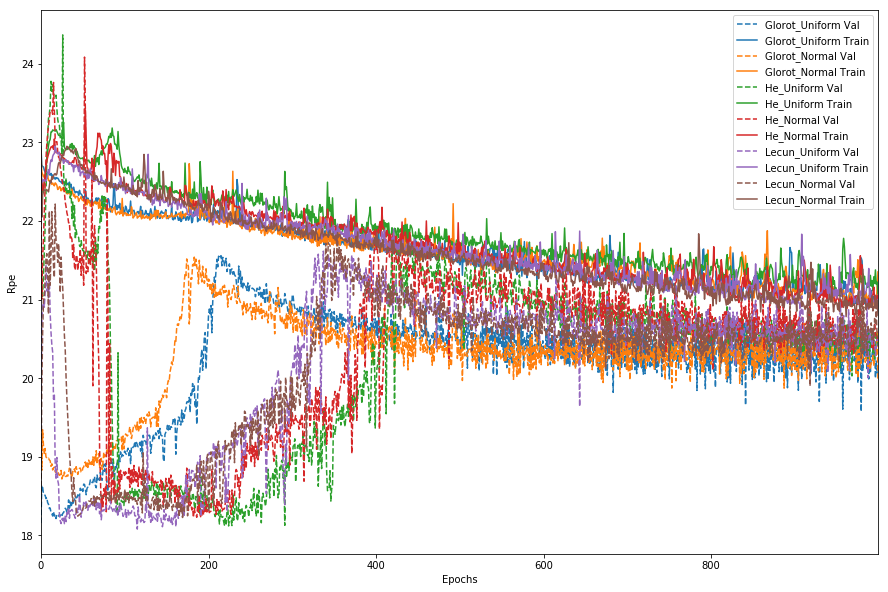

In [22]:
def plot_history(histories, key=  'rpe'):
  plt.figure(figsize=(15,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('glorot_uniform', history1),
         
             ('glorot_normal', history2),
             ('he_uniform', history3),
             ('he_normal', history4),
              ('lecun_uniform', history5),
              ('lecun_normal', history6)])

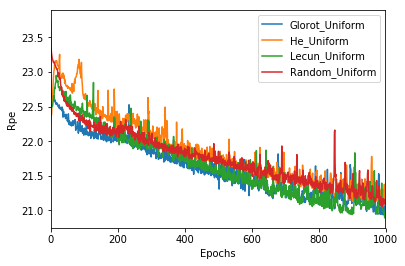

In [23]:
def plot_history(histories, key=  'rpe'):
  #plt.figure(figsize=(15,10))
    
  for name, history in histories:
    
    plt.plot(history.epoch, history.history[key],
             label=name.title())

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('glorot_uniform', history1),
         
             
             ('he_uniform', history3),
     
              ('lecun_uniform', history5),
              ('random_uniform', history7)])

In [24]:
#Extract the weights of each model per layer:

w_glorot = []
w_lecun = []
w_he=[]
w_random=[]

for i in range(len(model_glorot.layers)):
    #w_relu.append(max(model_relu.layers[i].get_weights()[1]))
    
    w_glorot.append(model_glorot.layers[0].get_weights()[1].max())
    w_lecun.append(model_lecun.layers[0].get_weights()[1].max())
    w_he.append(model_he.layers[0].get_weights()[1].max())
    w_random.append(model_random.layers[0].get_weights()[1].max())
    
    #w_tanh.append(max(model_tanh.layers[i].get_weights()[1]))

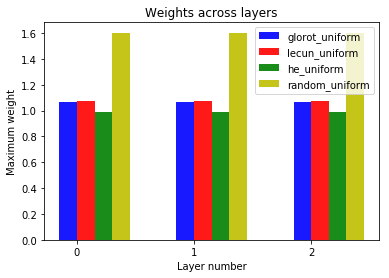

In [25]:
#Plot weight of both the models

fig, ax = plt.subplots()

index = np.arange(len(model_glorot.layers))
bar_width = 0.15

plt.bar(index, w_glorot, bar_width, label='glorot_uniform', color='b', alpha=0.9)
plt.bar(index + bar_width, w_lecun, bar_width, label='lecun_uniform', color='r', alpha=0.9)
plt.bar(index + 2*bar_width, w_he, bar_width, label='he_uniform', color='g', alpha=0.9)
plt.bar(index + 3*bar_width, w_random, bar_width, label='random_uniform', color='y', alpha=0.9)
plt.title('Weights across layers')
plt.xlabel('Layer number')
plt.ylabel('Maximum weight')
plt.legend(loc=0)

plt.xticks(index + bar_width / 2, np.arange(8))
plt.show()